In [10]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import yaml

cm_data = np.loadtxt("ColorMaps/lajolla.txt")
cm_datavik = np.loadtxt("ColorMaps/vik.txt")
cm_databamako = np.loadtxt("ColorMaps/bamako.txt")
lajolla = LinearSegmentedColormap.from_list("lajolla", cm_data)
vik = LinearSegmentedColormap.from_list("vik", cm_datavik)
bamako = LinearSegmentedColormap.from_list("bamako", cm_databamako)
folder = "./WITH_DTCMB/"

In [2]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

lajolla_r = reverse_colourmap(lajolla)

In [3]:
def file(M, Fe, FeM=0):
    return folder+"data_prof_M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2d}.0000.res".format(M, Fe, FeM)

def find_CMB(profiles):
    core = profiles[profiles["Material-Parameter"]==8.]
    index_max = core["r(m)"].idxmax()
    return index_max, core["r(m)"].iloc[0], core["p(GPa)"].iloc[0], core["T(K)"].iloc[0]
    
def center(profiles): 
    return profiles["r(m)"].iloc[-1], profiles["p(GPa)"].iloc[-1], profiles["T(K)"].iloc[-1]

def T_liquidus_mantle(P, FeM=0.):
    """ 5400 * (p/140)^{0.48} / (1 - ln(1-\#Fe_{\rm M}) ) """
    return 5400.*(P/140)**0.48/(1-np.log(1-FeM))

def T_liquidus_core(P, S=0.):
    """ T_{\rm melt} = 6500 * (p/340)^{0.515} / (1 - ln(1-X_{\rm S}) ) """
    return 6500.*(P/340)**0.515/(1-np.log(1-S))

def find_rIC(profiles, S):
    core = profiles[profiles["Material-Parameter"]==8.]
    Temperature = core["T(K)"].values
    Pressure = core["p(GPa)"].values
    Radius = core["r(m)"].values
    T_liq = T_liquidus_core(Pressure, S)
    index = np.argmin(np.abs(Temperature-T_liq))
    return Radius[index]

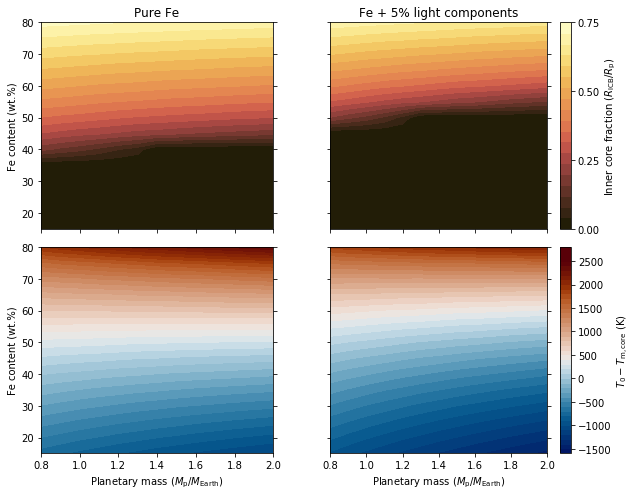

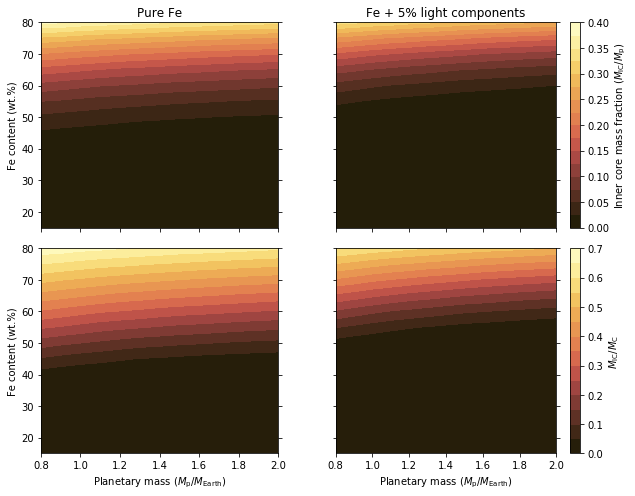

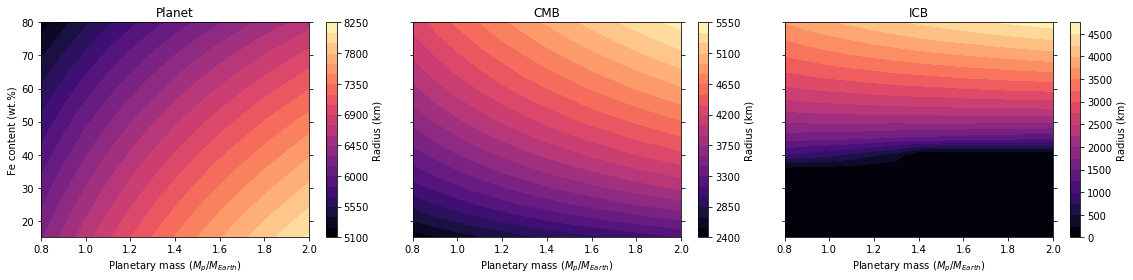

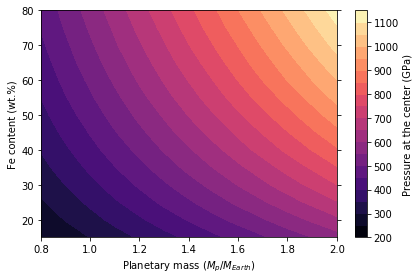

In [64]:
names = ["g(m/s^2)", "p(GPa)", "rho(kg/m^3)","r(m)", "T(K)", "oups", "Cp(J/kgK)", "alpha(10^-5 1/s)", "Gruneisen(1)", \
        "KT(GPa)", "KS(GPa)", "G(GPa)", "ElCond (Siemens)", "Material-Parameter" ]

Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.]
Fe = [15, 20, 25, 30, 35, 40, 45, 50,  55, 60,  65, 70,  75, 80]

M, F = np.meshgrid(Masses, Fe)
T_CMB = np.zeros_like(M)
P_CMB = np.zeros_like(M)
r_CMB = np.zeros_like(M)
T_0 = np.zeros_like(M)
P_0 = np.zeros_like(M)
r_0 = np.zeros_like(M)
rIC_005 = np.zeros_like(M)
rIC = np.zeros_like(M)
Rp = np.zeros_like(M)
Tl = np.zeros_like(M)
Tl_005 = np.zeros_like(M)

for i, mass in enumerate(Masses):
    for j, iron in enumerate(Fe):
        filename = file(mass, iron, 0)
        data = pd.read_csv(filename, skipinitialspace=True, sep=" ", names=names, index_col=False)
        index, r_CMB[j, i], P_CMB[j, i], T_CMB[j, i] = find_CMB(data)
        r_0[j, i], P_0[j, i], T_0[j, i] = center(data)
        rIC[j, i] = find_rIC(data, S=0)
        rIC_005[j, i] = find_rIC(data, S=0.05)
        Rp[j,i] = data["r(m)"].iloc[0]
        Tl = T_liquidus_core(P_0, S=0)
        Tl_005 = T_liquidus_core(P_0, S=0.05)

# ------------------------------------------------------------------------

fig, ax = plt.subplots(2, 2, figsize=[9,7],sharey=True,sharex=True)
levels_rIC = np.linspace(0, 0.75, 20)
levels_Tl = np.linspace(-1600, 2800, 45)
plt.subplots_adjust(wspace = 0.1)

sc = ax[0,0].contourf(M, F, (rIC/1e3)/(Rp/1e3), levels_rIC, cmap = lajolla_r)
ax[0,0].set_ylabel("Fe content (wt.%)")
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="1%", pad=0.5)
cax.axis('off')
ax[0,0].set_title("Pure Fe")
ax[0,0].yaxis.set_ticks_position('both')

sc = ax[1,0].contourf(M, F, Tl-T_0, levels_Tl, cmap = vik)
ax[1,0].set_xlabel("Planetary mass ($M_{\mathrm{p}}/M_{\mathrm{Earth}}$)")
ax[1,0].yaxis.set_ticks_position('both')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="1%", pad=0.5)
cax.axis('off')
ax[1,0].set_ylabel("Fe content (wt.%)")

sc = ax[0,1].contourf(M, F, (rIC_005/1e3)/(Rp/1e3), levels_rIC, cmap = lajolla_r)
cb  = fig.colorbar(sc, ax=ax[0,1], ticks=np.linspace(0, 1, 5))
cb.set_label("Inner core fraction ($R_{\mathrm{ICB}}/R_{\mathrm{p}}$)")
divider = make_axes_locatable(ax[0,1])
ax[0,1].set_title("Fe + 5% light components")
ax[0,1].yaxis.set_ticks_position('both')

sc = ax[1,1].contourf(M, F, Tl_005-T_0, levels_Tl, cmap = vik,vmin=-1600,vmax=2500)
cb  = fig.colorbar(sc, ax=ax[1,1])
cb.set_label("$T_{\mathrm{0}}-T_{\mathrm{m,core}}$ (K)")
ax[1,1].set_xlabel("Planetary mass ($M_{\mathrm{p}}/M_{\mathrm{Earth}}$)")
ax[1,1].yaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig("Figures/R_IC.pdf")


# ------------------------------------------------------------------------

fig, ax = plt.subplots(2, 2, figsize=[9,7],sharey=True,sharex=True)
levels_rIC = np.linspace(0, 0.4, 17)
levels_rIC_005 = np.linspace(0, 0.7, 15)

sc = ax[0,0].contourf(M, F, (rIC/Rp)**3, levels_rIC, cmap = lajolla_r)
ax[0,0].set_ylabel("Fe content (wt.%)")
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].set_title("Pure Fe")
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="1%", pad=0.5)
cax.axis('off')

sc = ax[0,1].contourf(M, F, (rIC_005/Rp)**3, levels_rIC, cmap = lajolla_r)
cb  = fig.colorbar(sc, ax=ax[0,1])
cb.set_label("Inner core mass fraction ($M_{\mathrm{IC}}/M_{\mathrm{p}}$)")
ax[0,1].yaxis.set_ticks_position('both')
ax[0,1].set_title("Fe + 5% light components")

sc = ax[1,0].contourf(M, F, (rIC/r_CMB)**3, levels_rIC_005, cmap = lajolla_r)
ax[1,0].set_ylabel("Fe content (wt.%)")
ax[1,0].set_xlabel("Planetary mass ($M_{\mathrm{p}}/M_{\mathrm{Earth}}$)")
ax[1,0].yaxis.set_ticks_position('both')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="1%", pad=0.5)
cax.axis('off')

sc = ax[1,1].contourf(M, F, (rIC_005/r_CMB)**3, levels_rIC_005, cmap = lajolla_r)
cb  = fig.colorbar(sc, ax=ax[1,1])
cb.set_label("$M_{\mathrm{IC}}/M_{\mathrm{C}}$")
ax[1,1].set_xlabel("Planetary mass ($M_{\mathrm{p}}/M_{\mathrm{Earth}}$)")
ax[1,1].yaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig("Figures/X_ICMF.pdf")
plt.show()


# ------------------------------------------------------------------------



fig, ax = plt.subplots(1, 3, figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

sc = ax[0].contourf(M, F, Rp/1e3, 20, cmap = plt.cm.magma)
ax[0].set_ylabel("Fe content (wt.%)")
cb  = fig.colorbar(sc, ax=ax[0])
cb.set_label("Radius (km)")
ax[0].set_title("Planet")
ax[0].yaxis.set_ticks_position('both')
ax[0].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
ax[0].yaxis.set_ticks_position('both')

sc = ax[1].contourf(M, F, r_CMB/1e3, 20, cmap = plt.cm.magma)
ax[1].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
ax[1].yaxis.set_ticks_position('both')
cb  = fig.colorbar(sc, ax=ax[1])
cb.set_label("Radius (km)")
ax[1].set_title("CMB")

sc = ax[2].contourf(M, F, rIC/1e3, 20, cmap = plt.cm.magma)
ax[2].set_title("ICB")
ax[2].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
ax[2].yaxis.set_ticks_position('both')
cb  = fig.colorbar(sc, ax=ax[2])
cb.set_label("Radius (km)")
plt.tight_layout()
plt.savefig("Figures/Radii_layers.pdf")

# ------------------------------------------------------------------------


fig, ax = plt.subplots(1, 1)
sc = ax.contourf(M, F, P_0, 20, cmap = plt.cm.magma)
ax.set_ylabel("Fe content (wt.%)")
cb  = fig.colorbar(sc)
cb.set_label("Pressure at the center (GPa)")
ax.yaxis.set_ticks_position('both')
ax.set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.savefig("Figures/P0.pdf")

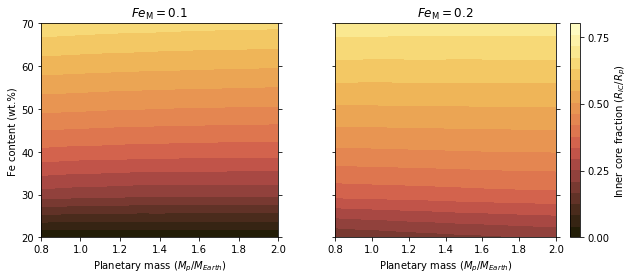

In [44]:
M, F = np.meshgrid(Masses, Fe)
T_CMB = np.zeros_like(M)
P_CMB = np.zeros_like(M)
r_CMB = np.zeros_like(M)
T_0 = np.zeros_like(M)
P_0 = np.zeros_like(M)
r_0 = np.zeros_like(M)
rIC = np.zeros_like(M)
rIC_10 = np.zeros_like(M)
rIC_20 = np.zeros_like(M)
Rp = np.zeros_like(M)
Tl_0 = np.zeros_like(M)
Tl = np.zeros_like(M)

for i, mass in enumerate(Masses):
    for j, iron in enumerate(Fe):
        filename = file(mass, iron, 10)
        data = pd.read_csv(filename, skipinitialspace=True, sep=" ", names=names, index_col=False)
        rIC_10[j, i] = find_rIC(data, S=0)
        Rp[j,i] = data["r(m)"].iloc[0]


for i, mass in enumerate(Masses):
    for j, iron in enumerate(Fe):
        filename = file(mass, iron, 20)
        data = pd.read_csv(filename, skipinitialspace=True, sep=" ", names=names, index_col=False)
        rIC_20[j, i] = find_rIC(data, S=0)
        Rp[j,i] = data["r(m)"].iloc[0]

fig, ax = plt.subplots(1, 2, figsize=[9,4],sharey=True,sharex=True)
levels_rIC = np.linspace(0, 0.8, 20)
levels_Tl = np.linspace(-1600, 2800, 45)
plt.subplots_adjust(wspace = 0.1)

sc = ax[0].contourf(M, F, (rIC_10/1e3)/(Rp/1e3), levels_rIC, cmap = lajolla_r)
ax[0].set_ylabel("Fe content (wt.%)")
ax[0].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="1%", pad=0.5)
cax.axis('off')
ax[0].set_title("$Fe_{\mathrm{M}}=0.1$")
ax[0].yaxis.set_ticks_position('both')

sc = ax[1].contourf(M, F, (rIC_20/1e3)/(Rp/1e3), levels_rIC, cmap = lajolla_r)
cb  = fig.colorbar(sc, ax=ax[1], ticks=np.linspace(0, 1, 5))
cb.set_label("Inner core fraction ($R_{IC}/R_{p}$)")
divider = make_axes_locatable(ax[1])
ax[1].set_title("$Fe_{\mathrm{M}}=0.2$")
ax[1].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
ax[1].yaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig("Figures/R_IC_FeM.pdf")

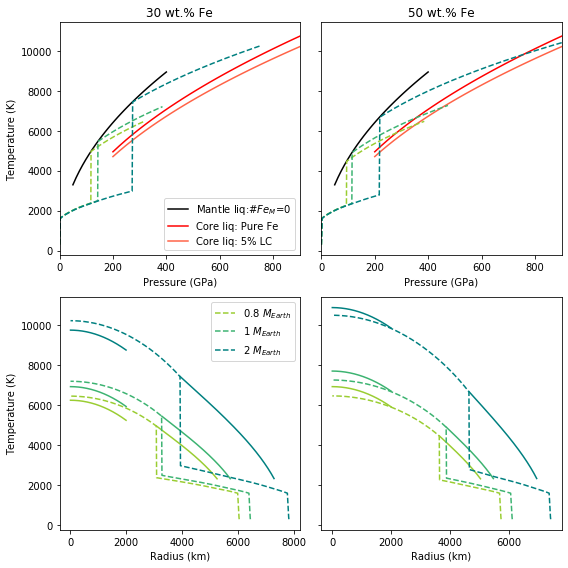

In [7]:
names = ["g(m/s^2)", "p(GPa)", "rho(kg/m^3)","r(m)", "T(K)", "oups", "Cp(J/kgK)", "alpha(10^-5 1/s)", "Gruneisen(1)", \
        "KT(GPa)", "KS(GPa)", "G(GPa)", "ElCond (Siemens)", "Material-Parameter" ]

fig, ax = plt.subplots(2, 2, sharey=True, figsize=[8, 8])

def file(M, Fe, FeM=0):
    return folder+"data_prof_M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2d}.0000.res".format(M, Fe, FeM)

mark = ["--","--","--"]
masses = np.array([0.8, 1.0, 2.0])
cm = ["yellowgreen","mediumseagreen","teal"]

P = np.linspace(50, 400, 30)
ax[0,0].plot(P, T_liquidus_mantle(P,0), color="k", label="Mantle liq:#$Fe_{M}$=0")
ax[0,1].plot(P, T_liquidus_mantle(P,0), color="k")

P = np.linspace(200, 900, 30)
ax[0,0].plot(P, T_liquidus_core(P), "r", label="Core liq: Pure Fe")
ax[0,0].plot(P, T_liquidus_core(P, 0.05), "tomato", label="Core liq: 5% LC")
ax[0,1].plot(P, T_liquidus_core(P), "r")
ax[0,1].plot(P, T_liquidus_core(P, 0.05),"tomato")

label = ["0.8 $M_{Earth}$","1 $M_{Earth}$","2 $M_{Earth}$"]
for i, mass in enumerate(masses):
    data = pd.read_csv(file(mass, 30, 0), skipinitialspace=True, sep=" ", names=names, index_col=False)
    if i==0:
        ax[0,0].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i])
    else:
        ax[0,0].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i], label= "")
    ax[1,0].plot(data["r(m)"]/1e3, data["T(K)"], mark[i], color=cm[i],label=label[i])
    deep_mantle = data[(data["Material-Parameter"] == 7.) | (data["Material-Parameter"] == 6.)]
    core = data[(data["r(m)"] <2e6)]
    ax[1,0].plot(deep_mantle["r(m)"]/1e3, T_liquidus_mantle(deep_mantle["p(GPa)"]), color=cm[i], label="")
    ax[1,0].plot(core["r(m)"]/1e3, T_liquidus_core(core["p(GPa)"]), color=cm[i], label= "")

for i, mass in enumerate(masses):
    data = pd.read_csv(file(mass, 50, 0), skipinitialspace=True, sep=" ", names=names, index_col=False)
    if i==0:
        ax[0,1].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i])
    else:
        ax[0,1].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i], label= "")
    ax[1,1].plot(data["r(m)"]/1e3, data["T(K)"], mark[i], color=cm[i],label=label[i])
    deep_mantle = data[(data["Material-Parameter"] == 7.) | (data["Material-Parameter"] == 6.)]
    core = data[(data["r(m)"] <2e6)]
    ax[1,1].plot(deep_mantle["r(m)"]/1e3, T_liquidus_mantle(deep_mantle["p(GPa)"]), color=cm[i], label="")
    ax[1,1].plot(core["r(m)"]/1e3, T_liquidus_core(core["p(GPa)"]), color=cm[i], label= "")
    
ax[0,0].set_xlabel("Pressure (GPa)")
ax[0,1].set_xlabel("Pressure (GPa)")
ax[1,0].set_xlabel("Radius (km)")
ax[1,1].set_xlabel("Radius (km)")
ax[0,0].set_ylabel("Temperature (K)")
ax[1,0].set_ylabel("Temperature (K)")
ax[0,0].set_xlim([0, 900])
ax[0,1].set_xlim([0, 900])
ax[0,0].legend()
ax[0,0].set_title('30 wt.% Fe')
ax[0,1].set_title('50 wt.% Fe')
ax[1,0].legend()
plt.tight_layout()
plt.savefig("Figures/Temperature_profiles_Fex.pdf")

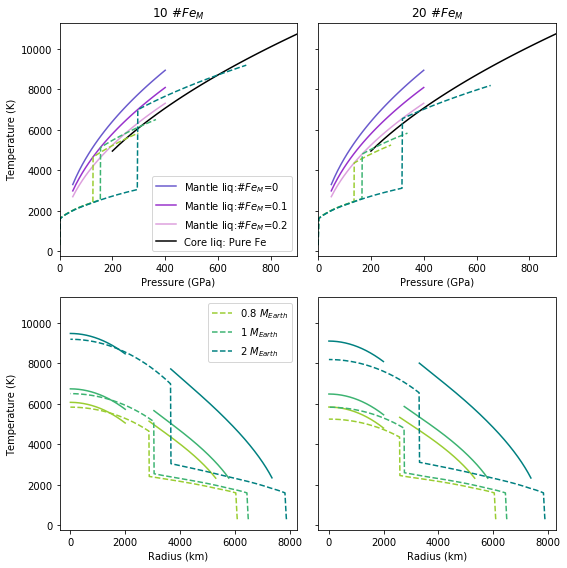

In [8]:
names = ["g(m/s^2)", "p(GPa)", "rho(kg/m^3)","r(m)", "T(K)", "oups", "Cp(J/kgK)", "alpha(10^-5 1/s)", "Gruneisen(1)", \
        "KT(GPa)", "KS(GPa)", "G(GPa)", "ElCond (Siemens)", "Material-Parameter" ]

fig, ax = plt.subplots(2, 2, sharey=True, figsize=[8, 8])

def file(M, Fe, FeM=0):
    return folder+"data_prof_M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2d}.0000.res".format(M, Fe, FeM)

mark = ["--","--","--"]
mark2 = [":",":",":"]
masses = np.array([0.8, 1.0, 2.0])
cm = ["yellowgreen","mediumseagreen","teal"]

P = np.linspace(50, 400, 30)
ax[0,0].plot(P, T_liquidus_mantle(P,0), color="slateblue", label="Mantle liq:#$Fe_{M}$=0")
ax[0,1].plot(P, T_liquidus_mantle(P,0), color="slateblue")
ax[0,0].plot(P, T_liquidus_mantle(P,0.1), color="darkorchid", label="Mantle liq:#$Fe_{M}$=0.1")
ax[0,1].plot(P, T_liquidus_mantle(P,0.1), color="darkorchid")
ax[0,0].plot(P, T_liquidus_mantle(P,0.2), color="plum", label="Mantle liq:#$Fe_{M}$=0.2")
ax[0,1].plot(P, T_liquidus_mantle(P,0.2), color="plum")


P = np.linspace(200, 900, 30)
ax[0,0].plot(P, T_liquidus_core(P), "k", label="Core liq: Pure Fe")
ax[0,1].plot(P, T_liquidus_core(P), "k", label="Core liq: Pure Fe")


label = ["0.8 $M_{Earth}$","1 $M_{Earth}$","2 $M_{Earth}$"]
for i, mass in enumerate(masses):
    data = pd.read_csv(file(mass, 30, 10), skipinitialspace=True, sep=" ", names=names, index_col=False)
    if i==0:
        ax[0,0].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i])
    else:
        ax[0,0].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i], label= "")
    ax[1,0].plot(data["r(m)"]/1e3, data["T(K)"], mark[i], color=cm[i],label=label[i])
    deep_mantle = data[(data["Material-Parameter"] == 7.) | (data["Material-Parameter"] == 6.)]
    core = data[(data["r(m)"] <2e6)]
    ax[1,0].plot(deep_mantle["r(m)"]/1e3, T_liquidus_mantle(deep_mantle["p(GPa)"]), color=cm[i], label="")
    ax[1,0].plot(core["r(m)"]/1e3, T_liquidus_core(core["p(GPa)"]), color=cm[i], label= "")

for i, mass in enumerate(masses):
    data = pd.read_csv(file(mass, 30, 20), skipinitialspace=True, sep=" ", names=names, index_col=False)
    if i==0:
        ax[0,1].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i])
    else:
        ax[0,1].plot(data["p(GPa)"], data["T(K)"], mark[i], color=cm[i], label= "")
    ax[1,1].plot(data["r(m)"]/1e3, data["T(K)"], mark[i], color=cm[i],label=label[i])
    deep_mantle = data[(data["Material-Parameter"] == 7.) | (data["Material-Parameter"] == 6.)]
    core = data[(data["r(m)"] <2e6)]
    ax[1,1].plot(deep_mantle["r(m)"]/1e3, T_liquidus_mantle(deep_mantle["p(GPa)"]), color=cm[i], label="")
    ax[1,1].plot(core["r(m)"]/1e3, T_liquidus_core(core["p(GPa)"]), color=cm[i], label= "")
    
ax[0,0].set_xlabel("Pressure (GPa)")
ax[0,1].set_xlabel("Pressure (GPa)")
ax[1,0].set_xlabel("Radius (km)")
ax[1,1].set_xlabel("Radius (km)")
ax[0,0].set_ylabel("Temperature (K)")
ax[1,0].set_ylabel("Temperature (K)")
ax[0,0].set_xlim([0, 900])
ax[0,1].set_xlim([0, 900])
ax[0,0].legend()
ax[0,0].set_title('10 #$Fe_M$')
ax[0,1].set_title('20 #$Fe_M$')
ax[1,0].legend()
plt.tight_layout()
plt.savefig("Figures/Temperature_profiles_FeM.pdf")

## Plot Lrho and Arho

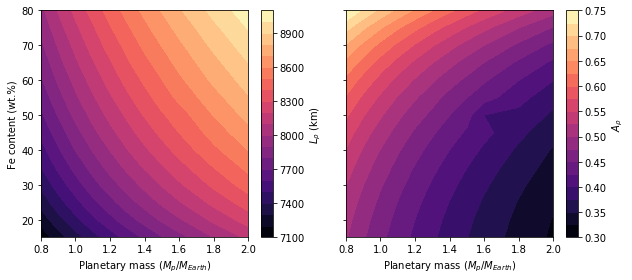

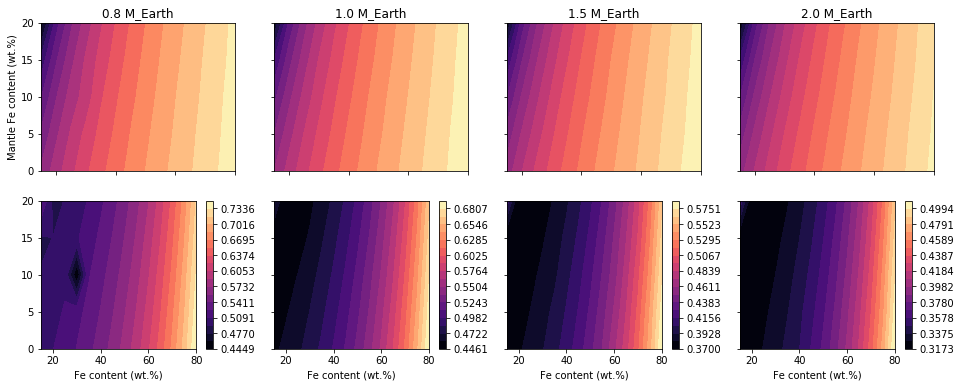

In [145]:
Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.]
Fe = [15,20 , 25, 30 ,35, 40 , 45, 50 , 55, 60 , 65, 70,75,80]
FeM = 0
S = 0.0

M, F = np.meshgrid(Masses, Fe)
L_rho = np.zeros_like(M)
A_rho = np.zeros_like(M)

for i, mass in enumerate(Masses):
    for j,iron in enumerate(Fe):
        Mp = mass
        XFe = iron
        data = open(folder+"/M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.yaml".format(Mp, XFe, FeM))
        data_p = yaml.load(data, Loader=yaml.FullLoader)
        L_rho[j,i] = data_p["L_rho"]
        A_rho[j,i] = data_p["A_rho"]
        
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[9, 4])
plt.subplots_adjust(wspace = 0.5)

L_rho = ax[0].contourf(M,F,L_rho/1e3, 20, cmap = plt.cm.magma)
cb  = fig.colorbar(L_rho, ax=ax[0])
ax[0].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
ax[0].set_ylabel("Fe content (wt.%)")
cb.set_label(r"$L_{\rho}$ (km)")
A_rho = ax[1].contourf(M,F,A_rho, 20, cmap = plt.cm.magma)
cb  = fig.colorbar(A_rho, ax=ax[1])
ax[1].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
cb.set_label(r"$A_{\rho}$")
plt.tight_layout()
plt.savefig("Figures/Lrho_Arho.pdf")
plt.show()
        
Masses = [0.8,1.0, 1.5, 2.]
Fe = [15,20 , 25, 30 ,35, 40 , 45, 50 , 55, 60 , 65, 70,75,80]
Fe_mantle = [0,5,10,15,20]

X, Y = np.meshgrid(Fe,Fe_mantle)
L_rho = np.zeros_like(X,dtype=np.float64)
A_rho = np.zeros_like(X,dtype=np.float64)

fig, ax = plt.subplots(2, 4, sharey=True, sharex=True, figsize=[16, 6])
plt.subplots_adjust(wspace = 0.2)

b = 0
for m,mass in enumerate(Masses):
    for i, iron in enumerate(Fe):
        for j,iron_mantle in enumerate(Fe_mantle):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            data = open(folder+"/M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.yaml".format(Mp, XFe, FeM))
            data_p = yaml.load(data, Loader=yaml.FullLoader)
            L_rho[j,i] = data_p["L_rho"]
            A_rho[j,i] = data_p["A_rho"]
    
#     levels_Lrho = np.linspace(np.min(L_rho), np.max(L_rho), 20)
    levels_Arho = np.linspace(np.min(A_rho), np.max(A_rho), 20)
            
    L_rho_plot = ax[0,b].contourf(X,Y,L_rho/1e3,20, cmap = plt.cm.magma)
    #cb  = fig.colorbar(L_rho_plot, ax=ax[0,b])
    ax[0,b].set_title("{:.1f} M_Earth".format(Mp))
    A_rho_plot = ax[1,b].contourf(X,Y,A_rho, levels_Arho, cmap = plt.cm.magma)
    cb  = fig.colorbar(A_rho_plot, ax=ax[1,b])
    ax[1,b].set_xlabel("Fe content (wt.%)")
    ax[0,0].set_ylabel("Mantle Fe content (wt.%)")
    b +=1
plt.show()